In [ ]:
#| default_exp cluster_launch

This notebook prepares the code to be launch in the cluster

In [1]:
#| export
import numpy as np
from joblib import Parallel, delayed
from tqdm.auto import tqdm

from rl_optimal_search.environment import target_search, is_c_between_ab, get_distance
from rl_optimal_search.diffusion_walks import lw_step, discrete_multiexp_step

In [2]:
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [8]:
def single_step_search(N, L, Nt, sampler_step, pos = None, **args_sampler):

    real_steps, sampled_steps, num_encounter = [], [], []
    
    if pos is None:
        pos = np.random.rand(N, 2)*L
    target_positions = np.random.rand(Nt, 2)*L

    steps = sampler_step(**args_sampler)

    angles = np.random.uniform(low = 0, high = 2*np.pi, size = N)
    pos_t = np.zeros_like(pos)
    pos_t[:, 0] = (pos[:, 0] + steps*np.cos(angles))%L
    pos_t[:, 1] = (pos[:, 1] + steps*np.sin(angles))%L            

    
    masked = np.array([False]*N)
    for idxT, pT in enumerate(target_positions):

        mask = is_c_between_ab(pos, pos_t, pT, radius = at)

        masked += np.array(mask)

        # Check real distance travelled
        if np.sum(mask) > 0:
            real_steps += np.linalg.norm(pos[mask == True, :].copy() - pT, axis = 1).tolist()
            

    num_encounter.append(np.sum(masked))

    return real_steps, steps, num_encounter

In [52]:
def single_step_search_flight(N, L, Nt, sampler_step, pos = None, **args_sampler):

    real_steps, sampled_steps, num_encounter = [], [], []
    
    if pos is None:
        pos = np.random.rand(N, 2)*L
    target_positions = np.random.rand(Nt, 2)*L

    steps = sampler_step(**args_sampler)

    angles = np.random.uniform(low = 0, high = 2*np.pi, size = N)
    pos_t = np.zeros_like(pos)
    pos_t[:, 0] = (pos[:, 0] + steps*np.cos(angles))%L
    pos_t[:, 1] = (pos[:, 1] + steps*np.sin(angles))%L 
    
    poses = np.vstack((pos_t, target_positions))
    dist_to_targ = get_distance(poses)[-Nt:,:-Nt]
    encounter = dist_to_targ[dist_to_targ < 2*np.pi]        

    num_encounter.append(np.sum(encounter))

    return steps, num_encounter

## LW

In [51]:
Nt = 4
N = 2*(10**5);
L = 200
at = 1

sampler_step = lw_step
alpha = 0.5

In [52]:
alphas = np.linspace(0.1, 2, 20)
reps = 100

effi_lw_w = np.zeros((reps, len(alphas)))
encs_lw_w = np.zeros_like(effi_lw_w)

   
for idxr in tqdm(range(reps)):

    for idx, alpha in enumerate(alphas):
        real_steps, steps, num_encounter = single_step_search(N=N, L=L, Nt = Nt,
                                                                  sampler_step=lw_step, alpha = alpha, num_part = N)
       

        effi_lw_w[idxr, idx] = num_encounter / np.sum(real_steps)
        encs_lw_w[idxr, idx] = num_encounter[0]

    
    

  0%|          | 0/100 [00:00<?, ?it/s]

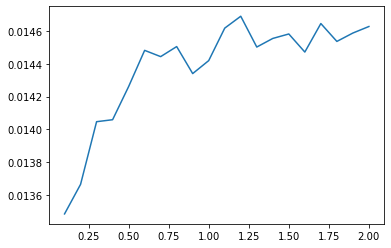

In [55]:
plt.plot(alphas, effi_lw_w.mean(0))

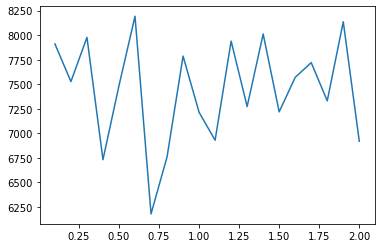

In [54]:
plt.plot(alphas, encs_lw_w[idxr])

### Flight

In [51]:
np.log(0.06)

-2.8134107167600364

In [53]:
Nt = 4
N = 2*(10**2);
L = 200
at = 1

sampler_step = lw_step
alpha = 0.5

In [55]:
reps = 3*int(1e4)
alphas = np.linspace(0.1, 2, 20)

effi_lw_f = np.zeros((reps, len(alphas)))
encs_lw_f = np.zeros_like(effi_lw_f)


for idxr in tqdm(range(reps)):

    for idx, alpha in enumerate(alphas):
        real_steps, num_encounter = single_step_search_flight(N=N, L=L, Nt = Nt,
                                                                      sampler_step=lw_step, alpha = alpha, num_part = N)
        effi_lw_f[idxr, idx] = num_encounter / np.sum(real_steps)
        encs_lw_f[idxr, idx] = num_encounter[0]

  0%|          | 0/30000 [00:00<?, ?it/s]

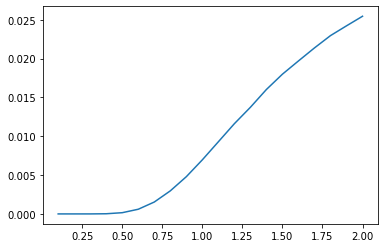

In [56]:
plt.plot(alphas, effi_lw_f.mean(0))

In [40]:
plt.plot(alphas, encs_lw_f.mean(0))

NameError: name 'encs_lw_f' is not defined

## Biexp

In [25]:
L**2

40000

In [18]:
Nt/L**2

0.0001

In [30]:
density = 1e-4
L = 1000
Nt = density*L**2

In [31]:
Nt

100.0

In [35]:
Nt = 4
N = 2*(10**4);
L = 200

density = 1e-4
L = 1000
Nt = int(density*L**2)

at = 1

x0 = np.sqrt(2)
pos = np.ones((N, 2))*x0

sampler_step = discrete_multiexp_step
ds = [L*10**3, x0]

In [36]:
w1s = np.logspace(-3,-1, 20)
reps = 100

effi = np.zeros((reps, len(w1s)))
encs = np.zeros_like(effi)

for idxr in tqdm(range(reps)):

    for idx, w1 in enumerate(w1s):



            ws = [w1, 1-w1]

            real_steps, sampled_steps, num_encounter = single_step_search(N=N, L=L, Nt = Nt, pos = pos,
                                                                          sampler_step=sampler_step, ws = ws, ds = ds, num_samples = N, L_max = 1e6)
            effi[idxr, idx] = num_encounter / np.sum(sampled_steps)
            encs[idxr, idx] = num_encounter[0]

  0%|          | 0/100 [00:00<?, ?it/s]

In [37]:
u,c = np.unique(sampled_steps, return_counts = True)

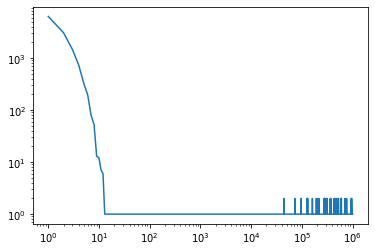

In [38]:
plt.loglog(u, c)

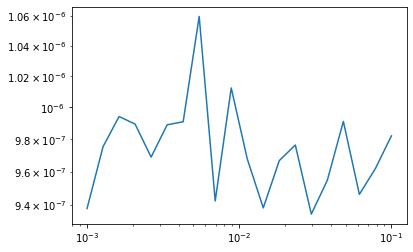

In [39]:
plt.loglog(w1s, effi.mean(0)
          )

In [56]:
from rl_optimal_search.diffusion_walks import multiexp_dist

In [58]:
multiexp_dist(np.arange(1, 100), ws, ds).sum()

0.5002474387538566

In [61]:
def multiexp_dist(x, ws, ds):
    val = 0
    for wi, di in zip(ws, ds):
        # discrete normalization from 1 to inf
        norm = (wi/di)/(np.exp(1/di)-1)
        val += (1/norm)* (wi/di) * np.exp(- x / di) 
    return val/len(ws)

In [68]:
ds

array([0.35658174, 0.92028455])

0.9966310096568345
0.9966310096568345
0.9966310096568345
0.9966310096568345
0.9966310096568345
0.9966310096568345
0.9966310096568345
0.9966310096568345
0.9966310096568345
0.9966310096568345


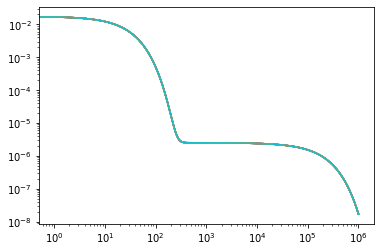

In [75]:
for idx in range(10):
    ws = [w1, 1-w1]
    #ds = np.random.rand(2)
    ds = [L*10**3, 20*x0]
    b = multiexp_dist(np.arange(1, 1000000), ws, ds)
    print(b.sum())

    plt.loglog(b)
# plt.ylim(ymin = 1e-3)